In [1]:
import random
import string
from dataclasses import dataclass
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.transforms import CenterCrop
from tqdm import tqdm

import precip
import wandb
from precip.data.dataset import InfiniteSampler, SwedishPrecipitationDataset, LOCAL_PRECIP_DATA_PATH
from precip.models.unet import UNet

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'


@dataclass(frozen=True)
class Config:
    model_name: str = "unet_64"
    training_batch_size: int = 2
    validation_batch_size: int = 2
    number_of_steps: int = 10
    training_size_per_step: int = 500
    validation_size_per_step: int = 1_000
    lr: float = 3e-4
    lr_scheduler_step: int = 3
    lr_scheduler_gamma: float = 0.85
    weight_decay: float = 1e-9
    intermediate_checkpointing: bool = False


def get_training_config() -> Config:
    return Config()

config = get_training_config()
path_to_state = Path('checkpoints/pleasant-water-70Q2Y2F/step_num_49.pth')

In [5]:
training_dataset = SwedishPrecipitationDataset(split="train")
validation_dataset = SwedishPrecipitationDataset(split="val")
output_transform = CenterCrop((128, 128))
training_dataloader = DataLoader(
    dataset=training_dataset,
    sampler=InfiniteSampler(training_dataset),
    batch_size=config.training_batch_size,
)
validation_dataloader = DataLoader(
    dataset=validation_dataset,
    sampler=InfiniteSampler(validation_dataset),
    batch_size=config.validation_batch_size,
)
train_dataiter = iter(training_dataloader)
val_dataiter = iter(validation_dataloader)

loss = nn.MSELoss()

In [10]:
payload = torch.load(path_to_state)

model = UNet(12, 1, base_channels=64).to('cuda')
model.load_state_dict(payload['model_state_dict'])
model = model.to(device)
model = model.eval()

### Training Example

In [11]:
with torch.no_grad():
    (batch_X, batch_y) = next(train_dataiter)
    batch_X, batch_y = batch_X.to(device), batch_y.squeeze(dim=1).to(device)
    out = model(batch_X)

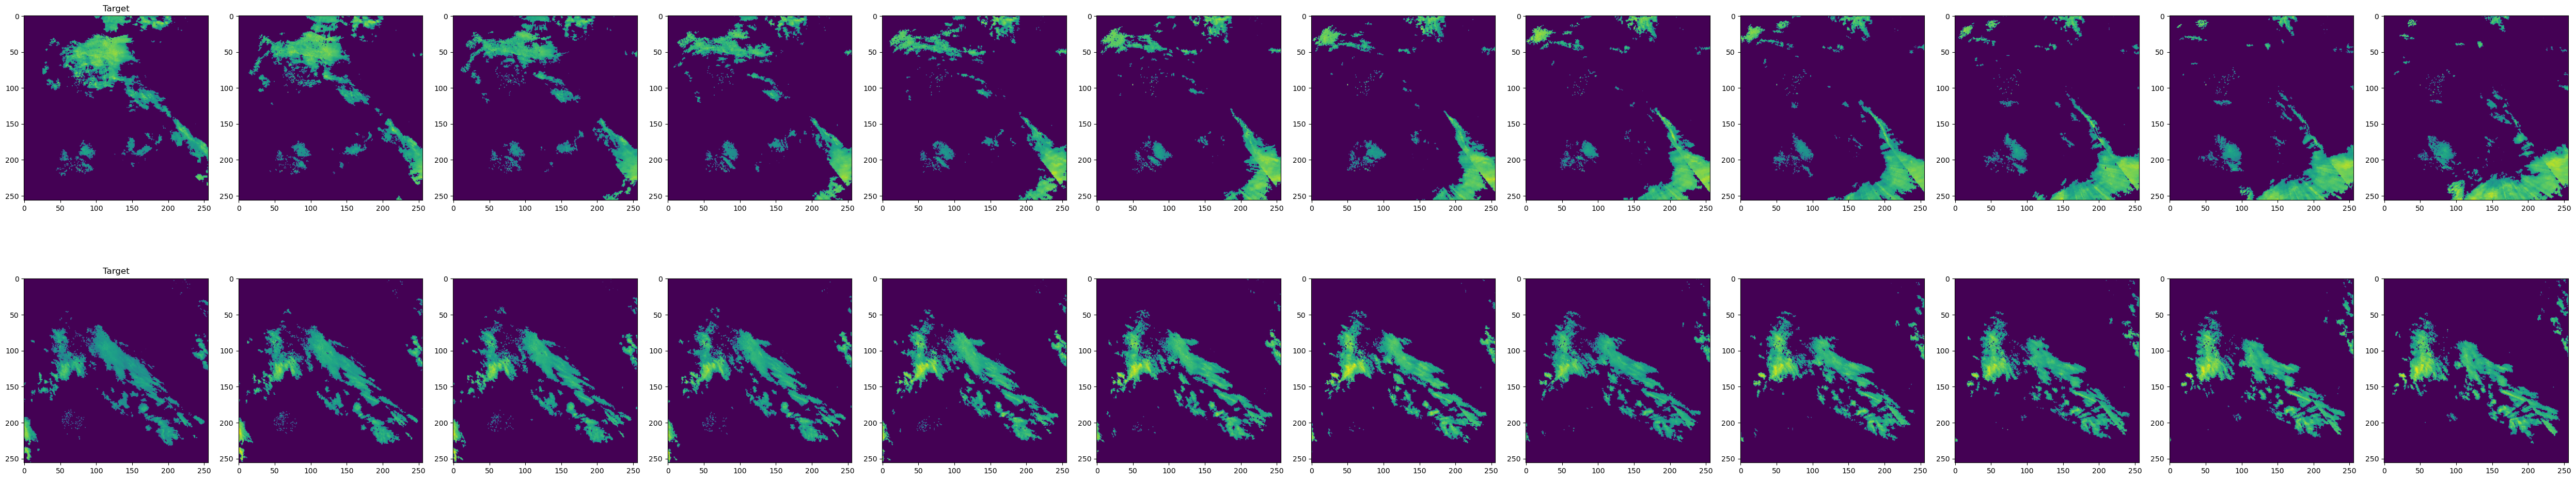

In [13]:
b, t = batch_X.shape[0], batch_X.shape[1]

f, axes = plt.subplots(b, t, figsize=(50, 11))

for x_idx in range(b):
    for y_idx in range(t):
        if y_idx == 0:
            axes[x_idx, y_idx].imshow(batch_y[x_idx].numpy())
            axes[x_idx, y_idx].set_title('Target')
        else:
            axes[x_idx, y_idx].imshow(batch_X[x_idx, y_idx-1].numpy())
        
        
f.tight_layout()

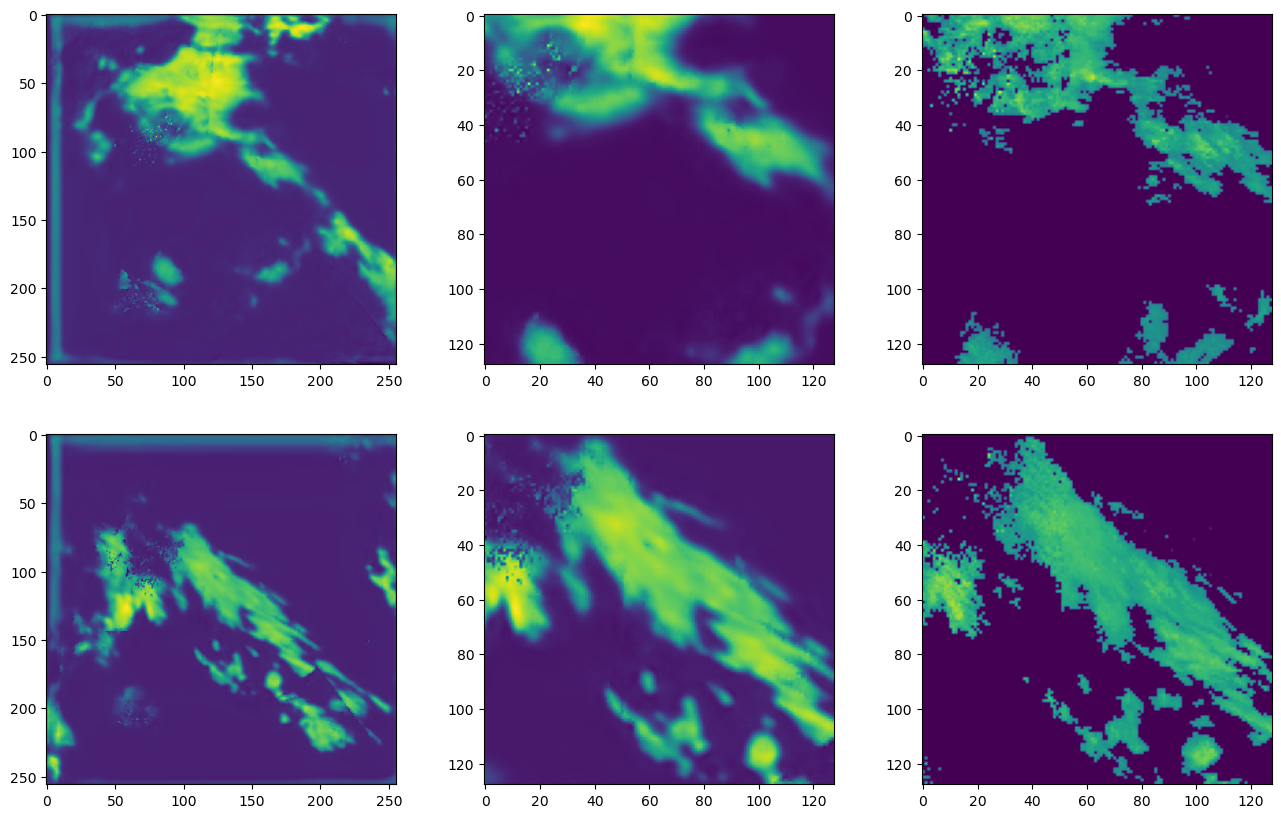

In [14]:
f, axes = plt.subplots(2, 3, figsize=(16, 10))

axes[0, 0].imshow(out[0].numpy())
axes[0, 1].imshow(output_transform(out[0]).numpy())
axes[0, 2].imshow(output_transform(batch_y[0]).numpy())
axes[1, 0].imshow(out[1].numpy())
axes[1, 1].imshow(output_transform(out[1]).numpy())
axes[1, 2].imshow(output_transform(batch_y[1]).numpy())

### Validation Example 

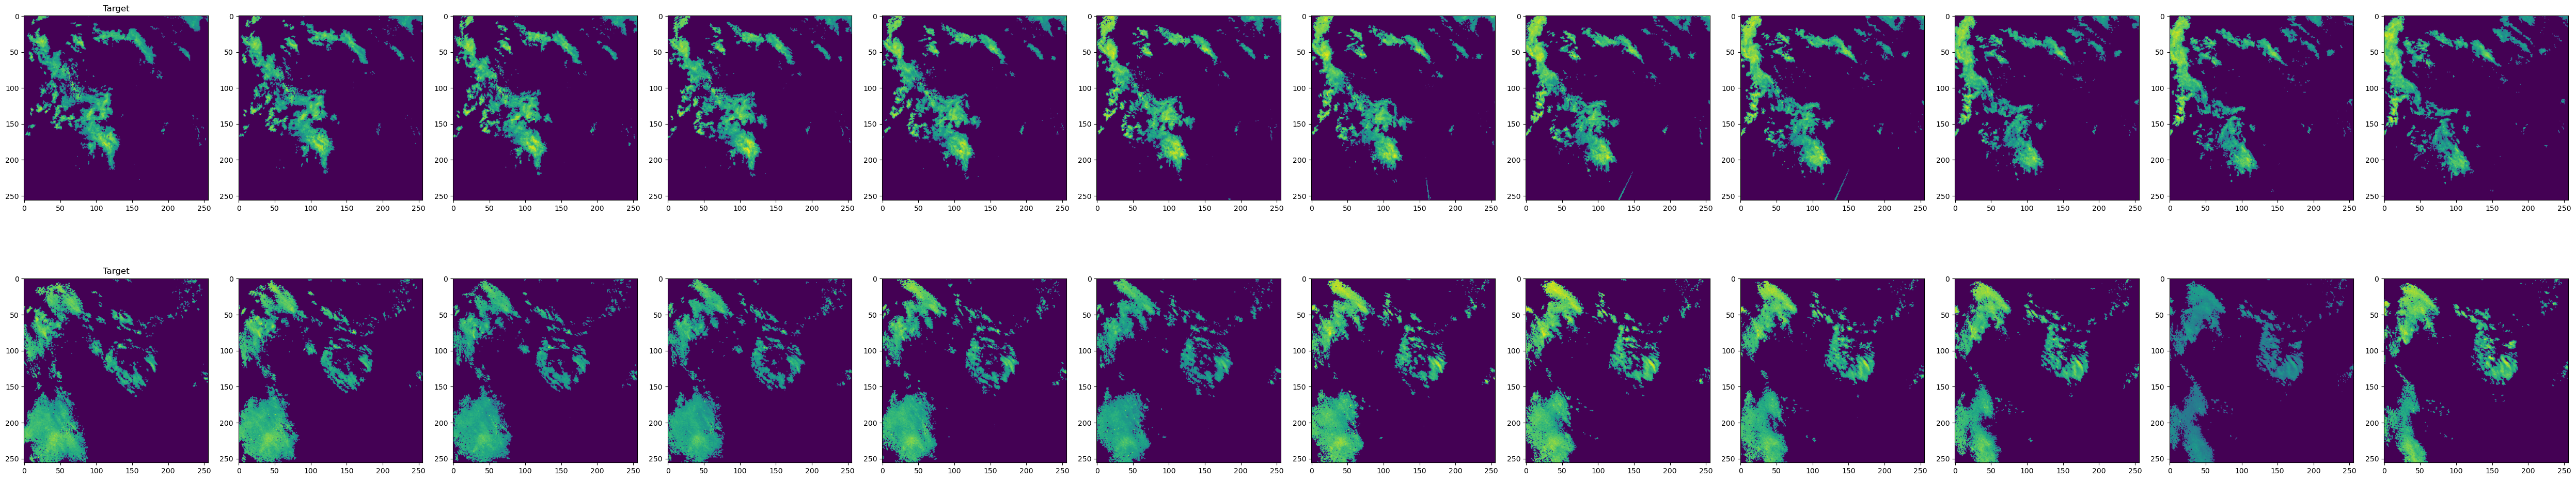

In [35]:
with torch.no_grad():
    (batch_X, batch_y) = next(val_dataiter)
    batch_X, batch_y = batch_X.to(device), batch_y.squeeze(dim=1).to(device)
    out = model(batch_X)

b, t = batch_X.shape[0], batch_X.shape[1]
f, axes = plt.subplots(b, t, figsize=(50, 11))

for x_idx in range(b):
    for y_idx in range(t):
        if y_idx == 0:
            axes[x_idx, y_idx].imshow(batch_y[x_idx].numpy())
            axes[x_idx, y_idx].set_title('Target')
        else:
            axes[x_idx, y_idx].imshow(batch_X[x_idx, y_idx-1].numpy())
        
        
f.tight_layout()

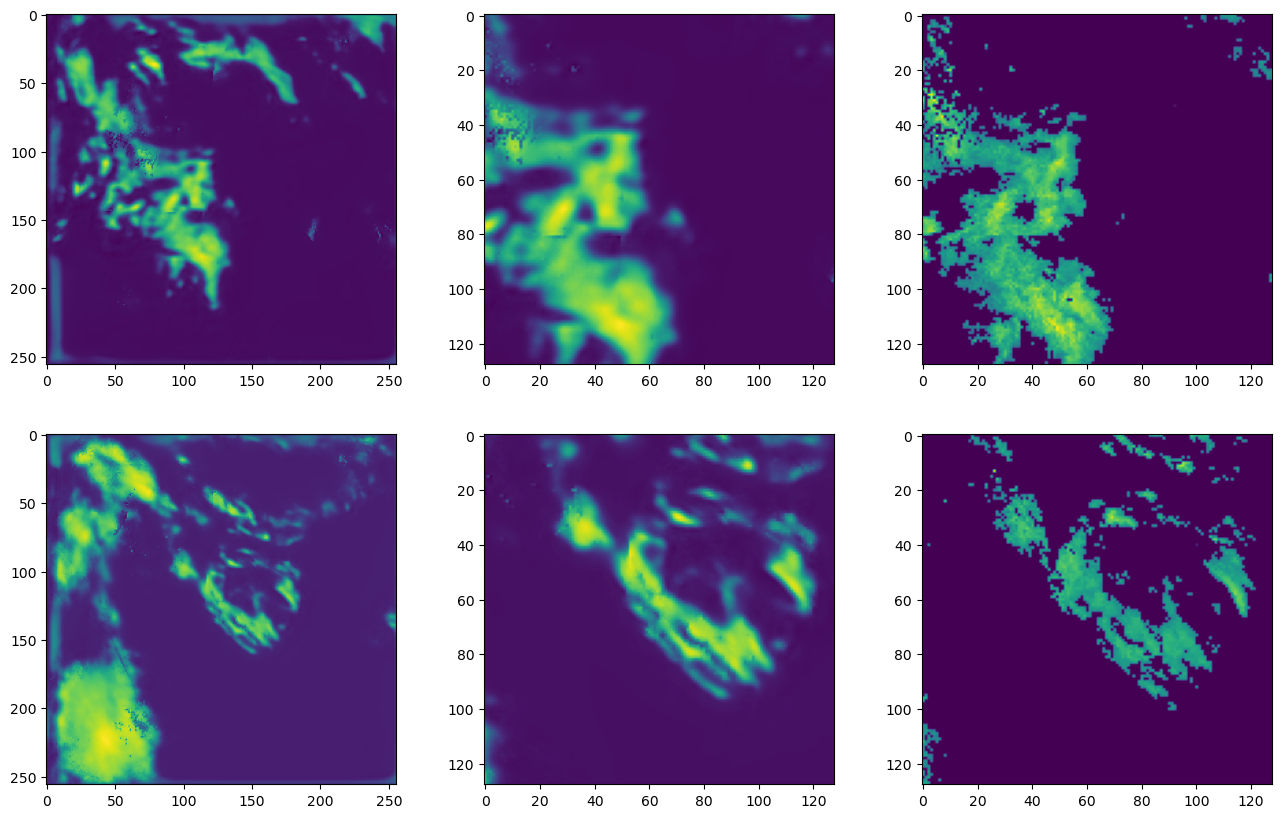

In [36]:
f, axes = plt.subplots(2, 3, figsize=(16, 10))

axes[0, 0].imshow(out[0].numpy())
axes[0, 1].imshow(output_transform(out[0]).numpy())
axes[0, 2].imshow(output_transform(batch_y[0]).numpy())
axes[1, 0].imshow(out[1].numpy())
axes[1, 1].imshow(output_transform(out[1]).numpy())
axes[1, 2].imshow(output_transform(batch_y[1]).numpy())

In [37]:
np.sqrt(loss(out, batch_y).item())

22.293804125643927

In [43]:
np.sqrt(loss(output_transform(batch_X[:, 0, :]), output_transform((batch_y))).item())

45.372384996961536

In [41]:
output_transform(batch_X[:, 0, :]).shape

torch.Size([2, 128, 128])

In [44]:
np.sqrt(loss(output_transform(batch_X[:, 0, :]), output_transform((batch_y))).item())

45.372384996961536

In [45]:
np.sqrt(loss(output_transform(out), output_transform((batch_y))).item())

19.988697673134403